In [155]:
import pandas as pd
import numpy as np

from training_data import import_training_set

In [180]:
# Use when doing regression
from sklearn.preprocessing import StandardScaler

# Read in data from file
data, __, rulesetIds = import_training_set("agents regression")
# data, __, rulesetIds = import_training_set("components regression")

# Prepare data
X = data.drop(columns=["Win rate of Agent 1"])
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = data["Win rate of Agent 1"]

In [178]:
# Use when doing classification
from sklearn.preprocessing import StandardScaler

# Read in data from file
data, __, rulesetIds = import_training_set("agents classification")
# data, __, rulesetIds = import_training_set("components classification")

# Prepare data
X = data.drop(columns=["Most common outcome for Agent 1"])
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = pd.get_dummies(data["Most common outcome for Agent 1"]) * 1

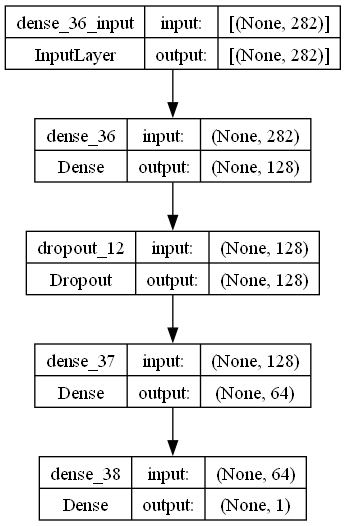

In [179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.utils import plot_model


# Define the model
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    # Dense(3, activation='sigmoid')  # Assuming 3 class classification
    Dense(1, activation='sigmoid')  # Assuming regression
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Save initial model weights
model.build(input_shape=(None, X.shape[1]))

initial_weights = model.get_weights()

# Plot model for visual inspection
plot_model(model, show_shapes=True, show_layer_names=True)

In [159]:
def regret_scores(true_labels, pred_labels):
    expected_value = (true_labels * pred_labels + (1 - true_labels) * (1 - pred_labels))
    regret = np.where(true_labels > 0.5, true_labels - expected_value, 1 - true_labels - expected_value)
    
    return regret

In [160]:
from tqdm import tqdm
from sklearn.metrics import f1_score

# Evaluate the model ruleset by ruleset -> assume that the model has not seen the supplied ruleset before

# Custom implementation of Leave-One-Out Cross-Validation
y_true = []
y_pred = []

for rulesetId in tqdm(np.unique(rulesetIds), desc='Processing rulesets'):
    # Train/test split
    X_train = X[rulesetIds != rulesetId]
    y_train = y[rulesetIds != rulesetId]

    X_test = X[rulesetIds == rulesetId]
    y_test = y[rulesetIds == rulesetId]

    # Reset model weights
    model.set_weights(initial_weights)

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict on the test instance
    # y_true += list(y_test)              # Use when doing regression
    y_true += list(np.array(y_test))    # Use when doing classification
    y_pred += list(model.predict(X_test, verbose=0))

Processing rulesets: 100%|██████████| 50/50 [27:10<00:00, 32.60s/it]


In [161]:
# Print evaluation metric depending on classification or regression

print(f"F1-score: {f1_score(y_true=y_true, y_pred=(y_pred == np.array(y_pred).max(axis=1, keepdims=1)), average='weighted')}")
# print(f"Regret-score: {regret_scores(np.array(y_true), np.array(y_pred).flatten()).mean()}")

F1-score: 0.6822717734559782


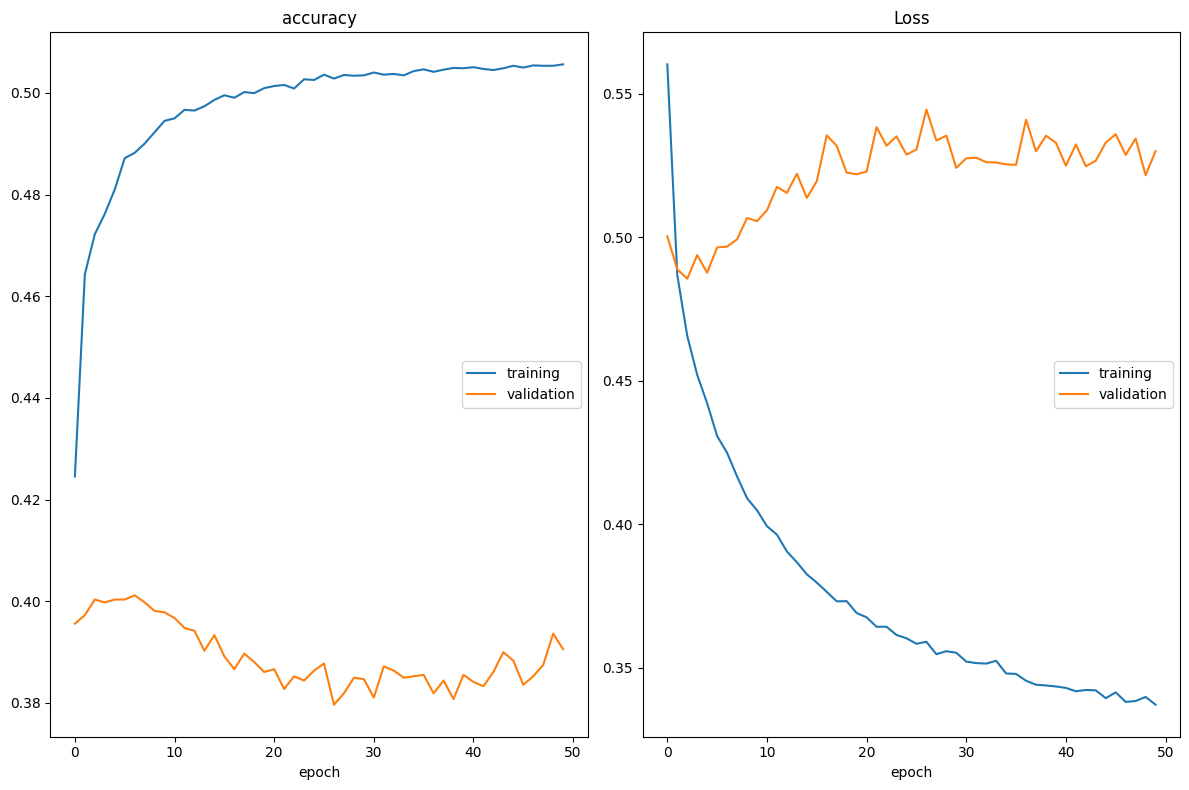

accuracy
	training         	 (min:    0.425, max:    0.506, cur:    0.506)
	validation       	 (min:    0.380, max:    0.401, cur:    0.391)
Loss
	training         	 (min:    0.337, max:    0.560, cur:    0.337)
	validation       	 (min:    0.486, max:    0.544, cur:    0.530)
448/448 [==============================] - 1s 2ms/step - loss: 0.3372 - accuracy: 0.5056 - val_loss: 0.5300 - val_accuracy: 0.3906


In [181]:
from livelossplot import PlotLossesKeras

# Reset model weights
model.set_weights(initial_weights)

# Train the final model
history = model.fit(X, y, epochs=50, batch_size=32, callbacks=[PlotLossesKeras()], validation_split=0.2)

In [9]:
# Get the weights of the first layer
weights, biases = model.layers[0].get_weights()

# Calculate the magnitude of the weights
weights_magnitude = np.sum(np.abs(weights), axis=1)

# Get the indices of the weights in descending order of magnitude
sorted_indices = np.argsort(weights_magnitude)[::-1]

# Display the top N weights with their indices and values
N = 30  # Number of top weights to display
for i in range(N):
    index = sorted_indices[i]
    value = weights_magnitude[index]
    print(f'Input {data.columns[index]} has a weight magnitude of {value}')

Input KintsBoard has a weight magnitude of 37.266780853271484
Input AsymmetricPiecesType has a weight magnitude of 33.519874572753906
Input Play-out 1 - Random has a weight magnitude of 31.07663345336914
Input NoMovesNext has a weight magnitude of 29.9560489654541
Input Play-out 2 - Random has a weight magnitude of 29.792083740234375
Input Selection 1 - Random has a weight magnitude of 29.48910140991211
Input Selection 2 - Random has a weight magnitude of 29.469097137451172
Input Scoring has a weight magnitude of 27.98230743408203
Input NumPlayPhase has a weight magnitude of 26.801746368408203
Input Play-out 2 - Random0 has a weight magnitude of 26.584049224853516
Input NoPieceNext has a weight magnitude of 25.271957397460938
Input SowCW has a weight magnitude of 25.23208236694336
Input TrackOwned has a weight magnitude of 24.999969482421875
Input Line has a weight magnitude of 24.979087829589844
Input LineOfSight has a weight magnitude of 24.746923446655273
Input Cell has a weight mag